In [1]:
#Dated 2nd August, 2022

import numpy as np # For array operations
import matplotlib.pyplot as plt
import cv2 as cv # Mostly for showing and normalization
import os #To iterate through directories and join paths
from sklearn import preprocessing
from random import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from random import randint
import h5py
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle

In [7]:
# Just some helper methods, that we will use later down the road

def resize_image(img_array, height, width):
    return cv.resize(img_array, (height, width))

def plot_image(img_array):
    plt.imshow(img_array, cmap='gray')
    plt.show()

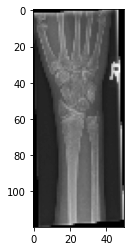

In [160]:
data_dir = r'D:\FYP\Dataset\Output Dataset\train'
classes = ['No-Pathologies', 'Pathological']
img_height = 120
img_width = 50

img_index = randint(0, 3000)
class_index = randint(0, 1)

img = cv.imread(os.path.join(os.path.join(data_dir, classes[class_index]), 
                             os.listdir(os.path.join(data_dir, classes[class_index]))[img_index]), cv.IMREAD_GRAYSCALE)
r_img = resize_image(img, img_width, img_height)

plt.imshow(r_img, cmap='gray')
plt.show()

In [2]:
# Creating training data
def get_data(data_dir, classes, img_width, img_height):
    data = []
    for a_class in classes:
        path = os.path.join(data_dir, a_class)
        class_num = classes.index(a_class)

        for image in os.listdir(path):
            img_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
            resized_img_array = resize_image(img_array, img_width, img_height)
            data.append([resized_img_array, class_num])
            
    return data

In [ ]:
training_data = get_data(data_dir, classes, img_width, img_height)

In [5]:
training_data[0]

[array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [ 90,  54,  40, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  66, 111, 169],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 0]

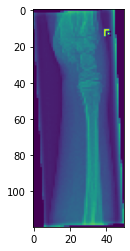

In [8]:
plt.imshow(training_data[0][0])
plt.show()

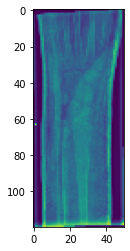

In [9]:
# Shuffling the training data (IMPORTANT)
shuffle(training_data)
plt.imshow(training_data[0][0])
plt.show()

In [10]:
# Seperating features from the labels
def sep_features_labels(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    return X, y

In [11]:
X_train, y_train = sep_features_labels(training_data)

In [12]:
#Reshaping the features 
def reshape(X, y, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 1)
    X = np.array(X).astype('float')/255.0
    # y_train = preprocessing.LabelEncoder().fit_transform(y_train)
    y = np.asarray(y).astype('float32').reshape((-1,1))
    
    return X, y

In [14]:
X_train, y_train = reshape(X_train, y_train, img_width, img_height)

In [3]:
def pickle_save(x_name, y_name, X, y):
    pickle_out = open(f'{x_name}.pickle', "wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()

    pickle_out = open(f'{y_name}.pickle', 'wb')
    pickle.dump(y, pickle_out)
    pickle_out.close()

In [4]:
def pickle_load(x_name, y_name):    
    pickle_in = open(f'{x_name}.pickle', 'rb')
    X = pickle.load(pickle_in)
    pickle_in.close()

    pickle_in = open(f'{y_name}.pickle', 'rb')
    y = pickle.load(pickle_in)
    pickle_in.close()
    return X, y

In [21]:
pickle_save('X_train', 'y_train', X_train, y_train)

In [5]:
X_train, y_train = pickle_load('X_train', 'y_train')

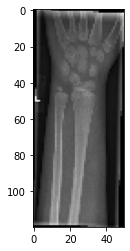

In [8]:
plot_image(X_train[5])

In [9]:
dense_layers = [1, 2]
layer_sizes = [128]
conv_layers = [ 4, 5 ]

s_models = []

for dense_layer in dense_layers:
	for layer_size in layer_sizes:
		for conv_layer in conv_layers:
			NAME = f'wri-{conv_layer}-conv-{layer_size}-layer-{dense_layer}-dense-{int(time.time())}'
			tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
            
			print(NAME)
			model = Sequential()
			model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:], activation='relu', data_format='channels_first'))
			model.add(BatchNormalization())
			model.add(MaxPooling2D(pool_size=(2, 2)))

			for i in range(conv_layer - 1):
				model.add(Conv2D(layer_size, (3, 3), activation='relu', data_format='channels_first'))
				model.add(MaxPooling2D(pool_size=(2, 2)))

			model.add(Flatten())
			for l in range(dense_layer):
				model.add(Dense(512, activation='relu'))
				model.add(Dropout(0.5))

			model.add(Dense(1, activation='sigmoid'))
			model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
			model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=10, callbacks=[tensorboard])
			val_loss, val_acc = model.evaluate(X_val, y_val)
			s_models.append([f'{NAME}, LOSS: {val_loss}, ACC: {val_acc}', model])

In [55]:
val_data = get_data(r'D:\FYP\Dataset\Output Dataset\val', classes, img_width, img_height)
shuffle(val_data)
X_val, y_val = sep_features_labels(val_data)
X_val, y_val = reshape(X_val, y_val, img_width, img_height)

In [56]:
pickle_save('X_val', 'y_val', X_val, y_val)

In [10]:
X_val, y_val = pickle_load('X_val', 'y_val')

In [30]:
conv_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=10, verbose=1)

Epoch 1/10
108/108 [==============================] - 5s 45ms/step - loss: 0.5381 - accuracy: 0.7206 - val_loss: 0.6493 - val_accuracy: 0.6679
Epoch 2/10
108/108 [==============================] - 5s 43ms/step - loss: 0.4871 - accuracy: 0.7628 - val_loss: 0.6102 - val_accuracy: 0.6723
Epoch 3/10
108/108 [==============================] - 5s 43ms/step - loss: 0.4649 - accuracy: 0.7738 - val_loss: 0.5936 - val_accuracy: 0.7316
Epoch 4/10
108/108 [==============================] - 5s 43ms/step - loss: 0.4416 - accuracy: 0.7880 - val_loss: 0.5720 - val_accuracy: 0.7604
Epoch 5/10
108/108 [==============================] - 5s 43ms/step - loss: 0.4239 - accuracy: 0.7968 - val_loss: 0.4970 - val_accuracy: 0.7584
Epoch 6/10
108/108 [==============================] - 5s 43ms/step - loss: 0.3967 - accuracy: 0.8154 - val_loss: 0.4689 - val_accuracy: 0.7715
Epoch 7/10
108/108 [==============================] - 5s 43ms/step - loss: 0.3762 - accuracy: 0.8255 - val_loss: 0.4691 - val_accuracy: 0.7840

In [15]:
for model_name, model in models:
    print(model_name)

wri-1-conv-32-layer-0-dense-1659619999, LOSS: 0.8248814344406128, ACC: 0.6735547184944153
wri-2-conv-32-layer-0-dense-1659620023, LOSS: 0.6774890422821045, ACC: 0.6787207722663879
wri-3-conv-32-layer-0-dense-1659620050, LOSS: 0.5798473954200745, ACC: 0.7444034218788147
wri-4-conv-32-layer-0-dense-1659620078, LOSS: 0.5151875615119934, ACC: 0.7729397416114807
wri-1-conv-64-layer-0-dense-1659620106, LOSS: 0.8373152613639832, ACC: 0.7052890658378601
wri-2-conv-64-layer-0-dense-1659620142, LOSS: 0.5737637281417847, ACC: 0.7542435526847839
wri-3-conv-64-layer-0-dense-1659620188, LOSS: 0.5170226693153381, ACC: 0.7712177038192749
wri-4-conv-64-layer-0-dense-1659620236, LOSS: 0.5026945471763611, ACC: 0.7813038229942322
wri-1-conv-128-layer-0-dense-1659620285, LOSS: 0.7631211876869202, ACC: 0.7102091312408447
wri-2-conv-128-layer-0-dense-1659620350, LOSS: 0.6071333289146423, ACC: 0.7461254596710205
wri-3-conv-128-layer-0-dense-1659620440, LOSS: 0.7194558382034302, ACC: 0.7335793375968933
wri-4-c

In [35]:
for model_name, model in s_models:
    print(model_name)

wri-1-conv-128-layer-1-dense-1659622051, LOSS: 1.2844340801239014, ACC: 0.6947109699249268
wri-2-conv-128-layer-1-dense-1659622171, LOSS: 0.6976880431175232, ACC: 0.7345633506774902
wri-3-conv-128-layer-1-dense-1659622274, LOSS: 0.5551664233207703, ACC: 0.7141451239585876
wri-4-conv-128-layer-1-dense-1659622376, LOSS: 0.4715929329395294, ACC: 0.8034440279006958


In [37]:
curr_model = s_models[len(s_models) - 1][1]
model_name = (s_models[-1][0]).split(', ')[0]

In [21]:
# serialize model to JSON
def save_model(model_name, model):
    model_json = model.to_json()
    with open(f"{model_name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{model_name}.h5")
    print("Saved model to disk")

In [22]:
# load json and create model\
def load_model(model_name):
    json_file = open(f'{model_name}.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    conv_model = model_from_json(loaded_model_json)
    # load weights into new model
    conv_model.load_weights(f"{model_name}.h5")
    print("Loaded model from disk")
    return conv_model

In [38]:
save_model(model_name, curr_model)

Saved model to disk


In [39]:
conv_model = load_model(model_name)

Loaded model from disk


In [40]:
conv_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [24]:
# Load testing data
testing_data = get_data(r'D:\FYP\Dataset\Output Dataset\test', classes, img_width, img_height)
X_test, y_test = sep_features_labels(testing_data)
X_test, y_test = reshape(X_test, y_test, img_width, img_height)

In [25]:
pickle_save('X_test', 'y_test', X_test, y_test)

In [26]:
X_test, y_test = pickle_load('X_test', 'y_test')

In [41]:
val_loss, val_acc = conv_model.evaluate(X_test, y_test)

64/64 [==============================] - 1s 10ms/step - loss: 0.4614 - accuracy: 0.8142


In [28]:
print(f'Loss = {val_loss}, Accuracy: {val_acc}')

Loss = 0.4933621883392334, Accuracy: 0.7944936156272888


In [29]:
def normalize_img(img):
    r_img = resize_image(img, img_width, img_height)
    r_img = img_to_array(r_img, data_format='channels_last')
    r_img = np.array(r_img).reshape(-1, img_height, img_width, 1)
    r_img = (np.array(r_img)).astype('float')/255.0
    return r_img

In [30]:
def get_img(img_path):
     img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
     r_img = resize_image(img, img_width, img_height)
     return r_img

In [31]:
def get_predicted_class(pred_prob):
    if pred_prob > .5:
        return classes[1]
    return classes[0]

In [32]:
def predict_class(img_path):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    r_img = normalize_img(img)
    predict = conv_model.predict(r_img)
    pred_prob = predict[0][0]
    return pred_prob, get_predicted_class(pred_prob)

In [190]:
test_data = []
for a_class in classes:
    path = os.path.join(r'D:\FYP\Dataset\Output Dataset\test', a_class)
    for img in os.listdir(path):
        test_data.append([os.path.join(path, img), a_class])
shuffle(test_data)

In [191]:
def get_random_img(data):
    i = randint(0, len(data) - 1)
    return data[i][0], data[i][1]

In [192]:
rand_img, actual_lbl = get_random_img(test_data)
print(f'Path: {rand_img}, Label: {actual_lbl}')

Path: D:\FYP\Dataset\Output Dataset\test\Pathological\2892_0326370961_01_WRI-L2_M002_1.png, Label: Pathological


In [213]:
# set manual image path
# img_path = r'D:\FYP\Dataset\Output Dataset\test\No-Pathologies\1003_0408953722_01_WRI-R1_M011_0.png'

rand_img, actual_lbl = get_random_img(test_data)
prob, class_label = predict_class(rand_img)
print(f'\nPredicted Label: {class_label}\nProbability of Pathology: {prob}\nActual Label: {actual_lbl}')

1/1 [==============================] - 0s 24ms/step

Predicted Label: Pathological
Probability of Pathology: 0.9900403618812561
Actual Label: Pathological


<function matplotlib.pyplot.show(close=None, block=None)>

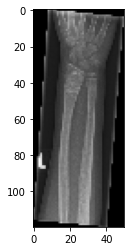

In [214]:
plt.imshow(read_img(rand_img), cmap='gray')
plt.show